# Comparisons with BGEP ULS sea ice draft estimates

In this notebook, we produce comparisons of the gridded ICESat-2 sea ice thickness data with draft measurements obtained from Upward Looking Sonar moorings deployed in the Beaufort Sea. 

Raw data link: https://www2.whoi.edu/site/beaufortgyre/data/mooring-data/2018-2021-mooring-data-from-the-bgep-project/


Notes: 

 - With more years of data we hope to explore de-seasonal trending of the data. Current tools (e..g seasonal_decompose from statsmodel) require more years of data then currently provided by the ICESat2-/BGEP overlap period (2018 to 2021)
 - Some previous studies have removed zero draft values from ULS before undertaking these comparisons. 
 - Could require a minimum number of IS2 grid-cells perhaps, would depend on scale. Note how in some September/October months there appears to be no data overlap.
 - could have made better use of Pandas but was a bit time pressured.
 

 

# Import notebook dependencies

In [181]:
import xarray as xr 
import pandas as pd
import numpy as np
import itertools
import pyproj 
from netCDF4 import Dataset
import scipy.interpolate 
from utils.read_data_utils import read_book_data # Helper function for reading the data from the bucket
from utils.plotting_utils import compute_gridcell_winter_means, interactiveArcticMaps, interactive_winter_mean_maps, interactive_winter_comparison_lineplot # Plotting
from scipy import stats

# Plotting dependencies
import cartopy.crs as ccrs
from textwrap import wrap
import hvplot.pandas
import holoviews as hv
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh # Helps avoid some weird issues with the polar projection 
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import statsmodels.api as sm

mpl.rcParams['figure.dpi'] = 300 # Sets figure size in the notebook

# Remove warnings to improve display
import warnings 
warnings.filterwarnings('ignore') 

In [182]:
# Read/download the data 
# NG: don't need the CryoSat-2 data here but could if you want to explore those comparisons too...
book_ds = read_book_data()

# Issue in how region mask was assigned
book_ds['region_mask'] = book_ds['region_mask'].isel(time=0, drop=True)

In [183]:
# Initialize map projection and project data to it

out_proj = 'EPSG:3411'
out_lons = book_ds.longitude.values
out_lats = book_ds.latitude.values

mapProj = pyproj.Proj("+init=" + out_proj)
xptsIS2, yptsIS2 = mapProj(out_lons, out_lats)

start_date = "Nov 2018"
end_date = "Apr 2021"
IS2_date_range = pd.date_range(start=start_date, end=end_date, freq='MS') # MS indicates a time frequency of start of the month
IS2_date_range = IS2_date_range[((IS2_date_range.month <5) | (IS2_date_range.month > 8))]
IS2_date_range_strs=[str(date.year)+'-%02d'%(date.month) for date in IS2_date_range]


In [184]:
# This is the value in meters of the aggreation length-scale for the ICESat-2 data
comp_res=100000

In [185]:
# Estimate ice draft from the ICESat-2 data for more direct comparison with ULS draft measurements
# NB: Another option (not taken) is to simply multiply ULS drafts by 1.1 to convert to thickness (AWI do this)

book_ds['ice_draft'] = book_ds['ice_thickness'] - book_ds['freeboard']+ book_ds['snow_depth']

In [186]:
dataPathULS='./data/'

def get_ULS_dates(uls_mean_monthly_draft, uls_dates, date):
    #print(date)
    a = uls_mean_monthly_draft[uls_dates==date].values[0]
    return a

def get_uls(letter):
    if letter=='a':
        # Mooring A (75.0 N, 150 W)
        uls_x, uls_y = mapProj(-150., 75.)
    if letter=='b':
        # Mooring B (78.4 N, 150.0 W)
        uls_x, uls_y = mapProj(-150., 78.4)
    if letter=='d':
        # Mooring D (74.0 N, 140.0 W)
        uls_x, uls_y = mapProj(-140., 74.)
 
    uls = pd.read_csv(dataPathULS+'uls18'+letter+'_draft.dat', sep='\s+',names = ['date', 'time', 'draft'], header=2)
    utc_datetime_uls = pd.to_datetime(uls['date'], format='%Y%m%d')
    uls_mean_daily_draft = uls['draft'].groupby([utc_datetime_uls.dt.date]).mean() 

    uls_mean_monthly_draft = uls['draft'].groupby([utc_datetime_uls.dt.to_period('m')]).mean() 
    #print(uls_mean_monthly_draft)
    
    return uls_mean_daily_draft, uls_mean_monthly_draft, uls_x, uls_y

uls_mean_daily_draft_a, uls_mean_monthly_draft_a, uls_x_a, uls_y_a = get_uls('a')
uls_mean_daily_draft_b, uls_mean_monthly_draft_b, uls_x_b, uls_y_b = get_uls('b')
uls_mean_daily_draft_d, uls_mean_monthly_draft_d, uls_x_d, uls_y_d = get_uls('d')


In [187]:
def grid_IS2_nearby(date, uls_x, uls_y, res=75000):
    #print(date)
    IS2 = book_ds.ice_draft.sel(time=date)
    xptsIS2=IS2.xgrid.values
    yptsIS2=IS2.ygrid.values
    dist = np.sqrt( (xptsIS2 - uls_x_a)**2 + (yptsIS2 - uls_y_a)**2 )
    
    IS2_uls = IS2.where(dist<res).mean()
    
    print('Number of valid IS-2 grid cells in month '+str(date)[0:7]+':', np.count_nonzero(~np.isnan(IS2.where(dist<res))))
    #Another option I first explored, coarsen the data then do nearest neighbor...provided similar results but above is more flexible.
    #if coarse_res>1:
    #Coarsen array by coarse_res in x/y directions (note that each grid-cell represents 25 km so 4 = 100 km)
    #    IS2 = IS2.coarsen(x=res, y=res, boundary='pad').mean()
    #IS_2_uls = scipy.interpolate.griddata((xptsIS2.flatten(),yptsIS2.flatten()), IS2.values.flatten(), (uls_x, uls_y), method = 'nearest')
    
    return IS2_uls


monthly_IS2_at_ULS_a  = [grid_IS2_nearby(date, uls_x_a, uls_y_a, res=comp_res) for date in IS2_date_range]
monthly_IS2_at_ULS_b  = [grid_IS2_nearby(date, uls_x_b, uls_y_b, res=comp_res) for date in IS2_date_range]
monthly_IS2_at_ULS_d  = [grid_IS2_nearby(date, uls_x_d, uls_y_d, res=comp_res) for date in IS2_date_range]

monthly_IS2_at_ULS_all = monthly_IS2_at_ULS_a+monthly_IS2_at_ULS_b+monthly_IS2_at_ULS_d


Number of valid IS-2 grid cells in month 2018-11: 52
Number of valid IS-2 grid cells in month 2018-12: 46
Number of valid IS-2 grid cells in month 2019-01: 52
Number of valid IS-2 grid cells in month 2019-02: 29
Number of valid IS-2 grid cells in month 2019-03: 51
Number of valid IS-2 grid cells in month 2019-04: 48
Number of valid IS-2 grid cells in month 2019-09: 0
Number of valid IS-2 grid cells in month 2019-10: 0
Number of valid IS-2 grid cells in month 2019-11: 43
Number of valid IS-2 grid cells in month 2019-12: 52
Number of valid IS-2 grid cells in month 2020-01: 50
Number of valid IS-2 grid cells in month 2020-02: 43
Number of valid IS-2 grid cells in month 2020-03: 48
Number of valid IS-2 grid cells in month 2020-04: 43
Number of valid IS-2 grid cells in month 2020-09: 25
Number of valid IS-2 grid cells in month 2020-10: 34
Number of valid IS-2 grid cells in month 2020-11: 49
Number of valid IS-2 grid cells in month 2020-12: 51
Number of valid IS-2 grid cells in month 2021-01

In [188]:
uls_dates=uls_mean_monthly_draft_a.index.astype(str)
uls_mean_monthly_draft_a_IS2_period  = [get_ULS_dates(uls_mean_monthly_draft_a, uls_dates, date) for date in IS2_date_range_strs]

uls_dates=uls_mean_monthly_draft_b.index.astype(str)
uls_mean_monthly_draft_b_IS2_period  = [get_ULS_dates(uls_mean_monthly_draft_b, uls_dates, date) for date in IS2_date_range_strs]

uls_dates=uls_mean_monthly_draft_d.index.astype(str)
uls_mean_monthly_draft_d_IS2_period  = [get_ULS_dates(uls_mean_monthly_draft_d, uls_dates, date) for date in IS2_date_range_strs]
                                        
uls_mean_monthly_draft_IS2_period = uls_mean_monthly_draft_a_IS2_period+uls_mean_monthly_draft_b_IS2_period+uls_mean_monthly_draft_d_IS2_period


In [189]:
# Seasonal plot

# Holoviews requires us to generate individual line plots then combine later
# Needed to reindex the pandas series to proper monthly datetime and offsetting to middle of the month

# Daily
uls_a_daily_lineplot_p = uls_mean_daily_draft_a.hvplot.line(grid=True, label="uls_daily", line_dash='solid', color='gray', frame_width=700, frame_height=200).opts( title='ULS A', xaxis=None, ylabel="Ice draft (meters)")
uls_b_daily_lineplot_p = uls_mean_daily_draft_b.hvplot.line(grid=True,  label="uls_daily", line_dash='solid', color='gray', frame_width=700, frame_height=200).opts(title='ULS B',xaxis=None, ylabel="Ice draft (meters)")
uls_d_daily_lineplot_p = uls_mean_daily_draft_d.hvplot.line(grid=True,  label="uls_daily", line_dash='solid', color='gray', frame_width=700, frame_height=200).opts(title='ULS D',ylabel="Ice draft (meters)")

# Monthly
ULS_date_range_a = pd.date_range(start=uls_mean_monthly_draft_a.index[0].to_timestamp().to_datetime64(), end=uls_mean_monthly_draft_a.index[-1].to_timestamp().to_datetime64(), freq='MS')+ datetime.timedelta(days=14)
uls_mean_monthly_draft_a_reindex = pd.Series(data=uls_mean_monthly_draft_a.values, index=ULS_date_range_a) 
uls_a_monthly_lineplot_p = uls_mean_monthly_draft_a_reindex.hvplot.line(grid=True, label="uls_monthly", line_dash='dashed', color='k', frame_width=700, frame_height=200).opts(ylabel="Ice draft (meters)")

ULS_date_range_b = pd.date_range(start=uls_mean_monthly_draft_b.index[0].to_timestamp().to_datetime64(), end=uls_mean_monthly_draft_b.index[-1].to_timestamp().to_datetime64(), freq='MS')+ datetime.timedelta(days=14)
uls_mean_monthly_draft_b_reindex = pd.Series(data=uls_mean_monthly_draft_b.values, index=ULS_date_range_b) 
uls_b_monthly_lineplot_p = uls_mean_monthly_draft_b_reindex.hvplot.line(grid=True, label="uls_monthly", line_dash='dashed', color='k', frame_width=700, frame_height=200).opts(ylabel="Ice draft (meters)")

ULS_date_range_d = pd.date_range(start=uls_mean_monthly_draft_d.index[0].to_timestamp().to_datetime64(), end=uls_mean_monthly_draft_d.index[-1].to_timestamp().to_datetime64(), freq='MS')+ datetime.timedelta(days=14)
uls_mean_monthly_draft_d_reindex = pd.Series(data=uls_mean_monthly_draft_d.values, index=ULS_date_range_d) 
uls_d_monthly_lineplot_p = uls_mean_monthly_draft_d_reindex.hvplot.line(grid=True, label="uls_monthly", line_dash='dashed', color='k', frame_width=700, frame_height=200).opts(ylabel="Ice draft (meters)")

# ICESat-2
is2_uls_mean_monthly_draft_a = pd.Series(data=monthly_IS2_at_ULS_a, index=IS2_date_range) 
is2_uls_a_monthly_lineplot_p = is2_uls_mean_monthly_draft_a.hvplot.scatter(grid=True, label="IS-2_monthly", marker='x', s=100, color='m', frame_width=700, frame_height=200)

is2_uls_mean_monthly_draft_b = pd.Series(data=monthly_IS2_at_ULS_b, index=IS2_date_range) 
is2_uls_b_monthly_lineplot_p = is2_uls_mean_monthly_draft_b.hvplot.scatter(grid=True, label="IS-2_monthly", marker='x', s=100, color='m', frame_width=700, frame_height=200)

is2_uls_mean_monthly_draft_d = pd.Series(data=monthly_IS2_at_ULS_d, index=IS2_date_range) 
is2_uls_d_monthly_lineplot_p = is2_uls_mean_monthly_draft_d.hvplot.scatter(grid=True, label="IS-2_monthly", marker='x', s=100, color='m', frame_width=700, frame_height=200)

# Combine plots and display
comb_plot = ((uls_a_daily_lineplot_p*uls_a_monthly_lineplot_p*is2_uls_a_monthly_lineplot_p).opts(legend_position='top_left') 
             + (uls_b_daily_lineplot_p*uls_b_monthly_lineplot_p*is2_uls_b_monthly_lineplot_p).opts(legend_position='top_left')
             + (uls_d_daily_lineplot_p*uls_d_monthly_lineplot_p*is2_uls_d_monthly_lineplot_p).opts(legend_position='top_left')).cols(1)

display(comb_plot)
hv.save(comb_plot, './figs/BGEP_seasonal_'+str(comp_res)+'.png', fmt='png', dpi=300)

:Layout
   .Overlay.I   :Overlay
      .Curve.Uls_daily                   :Curve   [date]   (draft)
      .Curve.Uls_monthly                 :Curve   [index]   (0)
      .Scatter.IS_hyphen_minus_2_monthly :Scatter   [index]   (0)
   .Overlay.II  :Overlay
      .Curve.Uls_daily                   :Curve   [date]   (draft)
      .Curve.Uls_monthly                 :Curve   [index]   (0)
      .Scatter.IS_hyphen_minus_2_monthly :Scatter   [index]   (0)
   .Overlay.III :Overlay
      .Curve.Uls_daily                   :Curve   [date]   (draft)
      .Curve.Uls_monthly                 :Curve   [index]   (0)
      .Scatter.IS_hyphen_minus_2_monthly :Scatter   [index]   (0)

In [190]:
# Validation analysis

# ULS A
mask = ~np.isnan(monthly_IS2_at_ULS_a)
res = stats.linregress(np.array(monthly_IS2_at_ULS_a)[mask], np.array(uls_mean_monthly_draft_a_IS2_period)[mask])

r_str_a = '%.02f' %(res[2]**2)
mb_str_a = '%.02f' %(np.nanmean(np.array(monthly_IS2_at_ULS_a)-np.array(uls_mean_monthly_draft_a_IS2_period)))
sd_str_a = '%.02f' %(np.nanstd(np.array(monthly_IS2_at_ULS_a)-np.array(uls_mean_monthly_draft_a_IS2_period)))

# ULS B
mask = ~np.isnan(IS2_ULS_b)
res = stats.linregress(np.array(monthly_IS2_at_ULS_b)[mask], np.array(uls_mean_monthly_draft_b_IS2_period)[mask])

r_str_b = '%.02f' %(res[2]**2)
mb_str_b = '%.02f' %(np.nanmean(np.array(monthly_IS2_at_ULS_b)-np.array(uls_mean_monthly_draft_b_IS2_period)))
sd_str_b = '%.02f' %(np.nanstd(np.array(monthly_IS2_at_ULS_b)-np.array(uls_mean_monthly_draft_b_IS2_period)))

# ULS D
mask = ~np.isnan(monthly_IS2_at_ULS_d)
res = stats.linregress(np.array(monthly_IS2_at_ULS_d)[mask], np.array(uls_mean_monthly_draft_d_IS2_period)[mask])

r_str_d = '%.02f' %(res[2]**2)
mb_str_d = '%.02f' %(np.nanmean(np.array(monthly_IS2_at_ULS_d)-np.array(uls_mean_monthly_draft_d_IS2_period)))
sd_str_d = '%.02f' %(np.nanstd(np.array(monthly_IS2_at_ULS_d)-np.array(uls_mean_monthly_draft_d_IS2_period)))

# ULS ALL
mask = ~np.isnan(monthly_IS2_at_ULS_all)
res = stats.linregress(np.array(monthly_IS2_at_ULS_all)[mask], np.array(uls_mean_monthly_draft_IS2_period)[mask])

r_str_all = '%.02f' %(res[2]**2)
mb_str_all = '%.02f' %(np.nanmean(np.array(monthly_IS2_at_ULS_all)-np.array(uls_mean_monthly_draft_IS2_period)))
sd_str_all = '%.02f' %(np.nanstd(np.array(monthly_IS2_at_ULS_all)-np.array(uls_mean_monthly_draft_IS2_period)))



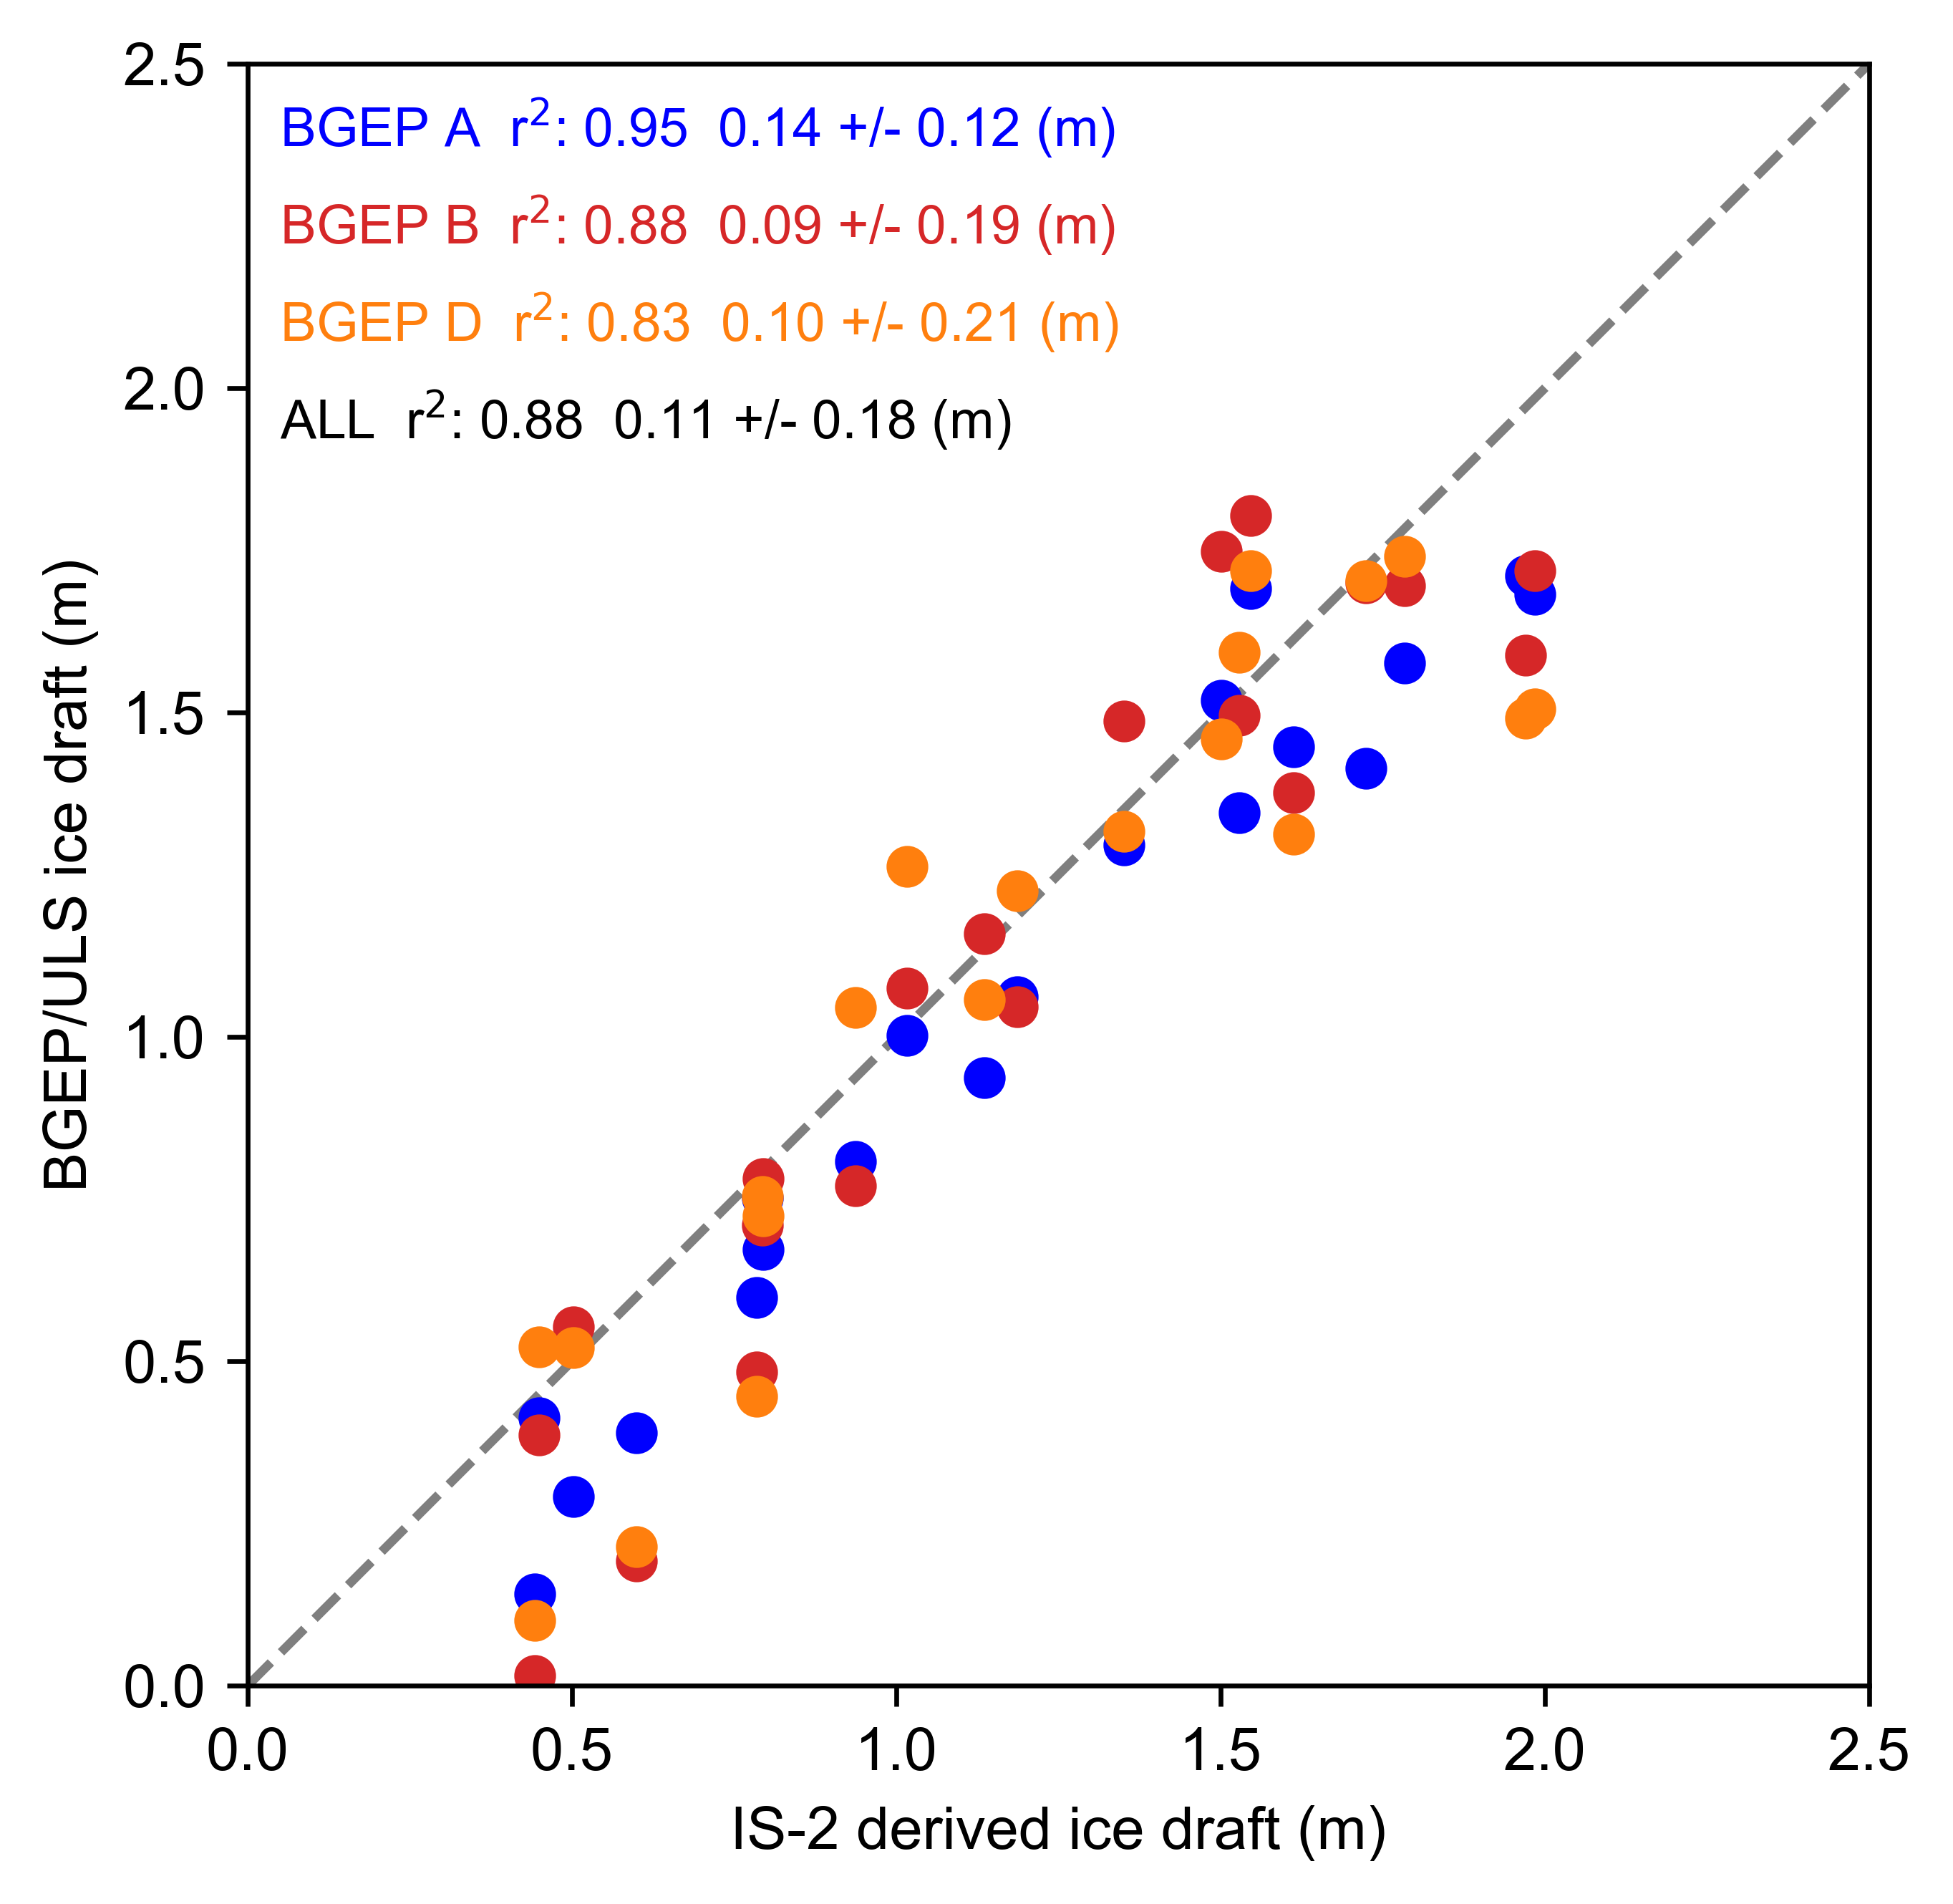

In [191]:
# Validation plot

plt.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
fig=plt.figure(figsize=(5, 5))
plt.scatter(monthly_IS2_at_ULS_a, uls_mean_monthly_draft_a_IS2_period, color='b')
plt.scatter(monthly_IS2_at_ULS_b, uls_mean_monthly_draft_b_IS2_period, color='tab:red')
plt.scatter(monthly_IS2_at_ULS_d, uls_mean_monthly_draft_d_IS2_period, color='tab:orange')
#plt.scatter(IS2_ULS_all, ULS_MONTHLY_IS2_all, color='k')

plt.annotate(r"BGEP A  r$^2$: "+r_str_a+"  "+mb_str_a+" +/- "+sd_str_a+" (m)", color='b', xy=(0.02, 0.98),xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=9)
plt.annotate(r"BGEP B  r$^2$: "+r_str_b+"  "+mb_str_b+" +/- "+sd_str_b+" (m)", color='tab:red', xy=(0.02, 0.92),xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=9)
plt.annotate(r"BGEP D  r$^2$: "+r_str_d+"  "+mb_str_d+" +/- "+sd_str_d+" (m)", color='tab:orange', xy=(0.02, 0.86),xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=9)
plt.annotate(r"ALL  r$^2$: "+r_str_all+"  "+mb_str_all+" +/- "+sd_str_all+" (m)", color='k', xy=(0.02, 0.80),xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', fontsize=9)
        
plt.ylabel('BGEP/ULS ice draft (m)')
plt.xlabel('IS-2 derived ice draft (m)')
plt.xlim([0, 2.5])
plt.ylim([0, 2.5])
ax=plt.gca()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against each other
ax.plot(lims, lims, 'k--', alpha=0.5, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.savefig('./figs/ULS_scatter_res'+str(comp_res)+'.pdf', dpi=200)
plt.show()
